In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure

In [2]:
iris = load_iris()
X, y = pd.DataFrame(iris.data, columns=iris.feature_names), iris.target
X, y

(     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4                  5.0               3.6                1.4               0.2
 ..                 ...               ...                ...               ...
 145                6.7               3.0                5.2               2.3
 146                6.3               2.5                5.0               1.9
 147                6.5               3.0                5.2               2.0
 148                6.2               3.4                5.4               2.3
 149                5.9               3.0                5.1               1.8
 
 [150 rows x 4 columns],
 array([0, 0, 0, 0, 0, 0,

In [3]:
def preprocess(df):
    df = df.copy(deep=True)
    return pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)

X = preprocess(X)
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


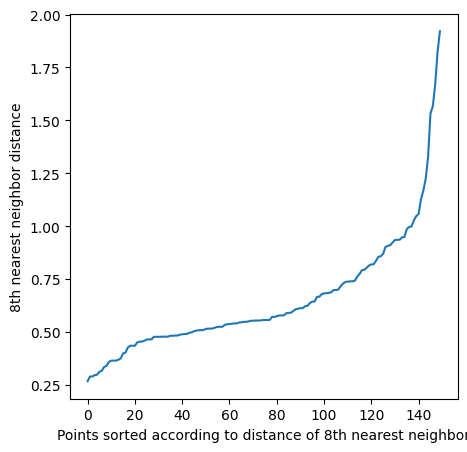

In [4]:
MIN_PTS = 2 * X.shape[1]

nearest_neighbors = NearestNeighbors(n_neighbors=MIN_PTS)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:, MIN_PTS-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points sorted according to distance of "+str(MIN_PTS)+"th nearest neighbor")
plt.ylabel(str(MIN_PTS)+"th nearest neighbor distance")
plt.show()

Taking the value of eps as `0.875` from the above plot.

In [5]:
dbscan = DBSCAN(min_samples=MIN_PTS, eps=0.875).fit(X)
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 7


[plot_dbscan](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#plot-results) modified to use PCA

In [6]:
def plot_dbscan(X, labels, core_samples_mask, n_clusters_):
    unique_labels = set(labels)
    pca_X = PCA(n_components=2).fit_transform(X)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for cluster_id, color in zip(unique_labels, colors):
        # Use black for noise (label -1)
        if cluster_id == -1:
            color = [0, 0, 0, 1]

        cluster_mask = labels == cluster_id

        core_samples_in_cluster = pca_X[cluster_mask & core_samples_mask]
        plt.plot(core_samples_in_cluster[:, 0], core_samples_in_cluster[:, 1], 'o', 
                 markerfacecolor=tuple(color), markeredgecolor='k', markersize=14)
        non_core_samples_in_cluster = pca_X[cluster_mask & ~core_samples_mask]
        plt.plot(non_core_samples_in_cluster[:, 0], non_core_samples_in_cluster[:, 1], 'o', 
                 markerfacecolor=tuple(color), markeredgecolor='k', markersize=6)

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()


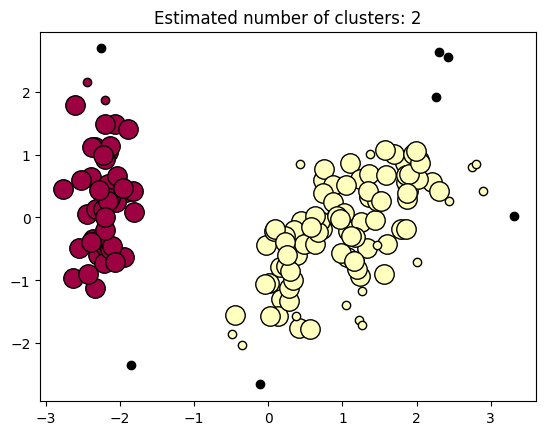

In [7]:
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

plot_dbscan(X, labels, core_samples_mask, n_clusters_)

In [8]:
# Internal measures
print("Silhouette_score: ", silhouette_score(X, dbscan.labels_))
print("Calinski_Harabasz_score", calinski_harabasz_score(X, dbscan.labels_))
print("Davies_Bouldin_score", davies_bouldin_score(X, dbscan.labels_))

# External measures
print("Adjusted_Rand_score", adjusted_rand_score(np.array(y), dbscan.labels_))
print("Normalized_Mutual_Info_score", normalized_mutual_info_score(np.array(y), dbscan.labels_))
print("Homogeneity_Completeness_V_Measure", homogeneity_completeness_v_measure(np.array(y), dbscan.labels_))

Silhouette_score:  0.5225742665342991
Calinski_Harabasz_score 112.88180486435053
Davies_Bouldin_score 3.3059296388139017
Adjusted_Rand_score 0.5359658179925626
Normalized_Mutual_Info_score 0.649248400546861
Homogeneity_Completeness_V_Measure (0.5601025897752989, 0.7721424274283182, 0.649248400546861)
